In [1]:
%reset -f

In [2]:
# Import packages
import os
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestRegressor

Load Dataframes & Dictionaries

In [3]:
base_path = os.path.join(os.getcwd(), "CBI Analysis_Actionable Insights")

# Load DFs (RandomForest is now our Default Model)
CBI_tot = pd.read_excel(os.path.join(base_path, "df_CBI_tot_analysis_rf.xlsx"))
CBI_term = pd.read_excel(os.path.join(base_path, "df_CBI_term_analysis_rf.xlsx"))
CBI_tot_corr = pd.read_excel(os.path.join(base_path, "df_CBI_tot_analysis_corr.xlsx"))
CBI_term_corr = pd.read_excel(os.path.join(base_path, "df_CBI_term_analysis_corr.xlsx"))
CBI_tot_unweighted = pd.read_excel(os.path.join(base_path, "df_CBI_analysis.xlsx"))
CBI_term_unweighted = pd.read_excel(os.path.join(base_path, "df_CBI_term_analysis.xlsx"))

# Load Dictionaries (RandomForest is now our Default Model)
weights_tot = pd.read_excel(os.path.join(base_path, "weights_rf_tot_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_term = pd.read_excel(os.path.join(base_path, "weights_rf_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_tot_corr = pd.read_excel(os.path.join(base_path, "weights_corr_tot_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_term_corr = pd.read_excel(os.path.join(base_path, "weights_corr_dict.xlsx"), index_col=0).squeeze("columns").to_dict()
weights_unweighted = {"DR": 1, "OFS": 1, "IAS": 1, "PCS": 1}

In [4]:
# Strategy: label Fall/Spring starting with the same year, to count them as the same academic year
# e.g. Fall 2021 & Spring 2022 will turn into 2021.0 and 2021.5, to group as the 2021 academic year

def semester_order_func(sem):
    season, year = sem.split()
    year = int(year)
    if season == "Fall":
        return year + 0.0           # Fall 2021 turns into 2021.0; Fall 2021 into 2022.0; etc
    elif season == "Spring":
        return (year - 1) + 0.5     # Spring 2022 - 1 + 0.5 = 2021.5 so that it'll follow Fall 2021.0

<h1>Analyzing CBI Total</h1>

CBI by Course 

In [5]:
# CBI Alphabetical
CBI_tot_alphabetical = CBI_tot[["Course Description", "CBI"]].sort_values(by="Course Description")

# CBI Highest to Lowest
CBI_tot_highlow = CBI_tot[["Course Description", "CBI"]].sort_values(by="CBI", ascending=False).reset_index(drop=True)

In [6]:
print("CBI Total Summary Stats:\n")

# Mean, median, standard deviation, min, max
cbi_tot_mean = round(CBI_tot["CBI"].mean(), 2)
cbi_tot_median = round(CBI_tot["CBI"].median(), 2)
cbi_tot_std = round(CBI_tot["CBI"].std(), 2)
cbi_tot_min = round(CBI_tot["CBI"].min(), 2)
cbi_tot_max = round(CBI_tot["CBI"].max(), 2)
print(f"Mean CBI: {cbi_tot_mean}")
print(f"Median CBI: {cbi_tot_median}")
print(f"Standard Deviation: {cbi_tot_std}")
print(f"Min CBI: {cbi_tot_min}")
print(f"Max CBI: {cbi_tot_max}")

# Quantiles
q1_cbi_tot = CBI_tot["CBI"].quantile(0.25)
q2_cbi_tot = CBI_tot["CBI"].median()  # or quantile(0.50)
q3_cbi_tot = CBI_tot["CBI"].quantile(0.75)
print("\nScoring Distribution (Quantiles):")
print(f"25% of the data has a CBI below: {q1_cbi_tot}")
print(f"50% of the data has a CBI below: {q2_cbi_tot}")
print(f"75% of the data has a CBI below: {q3_cbi_tot}")

# Top highest and lowest DR courses
high_low_count = 10
top_cbi_tot = CBI_tot.nlargest(high_low_count, "CBI")
bottom_cbi_tot = CBI_tot.nsmallest(high_low_count, "CBI")

print(f"\n{high_low_count} Highest CBI Courses:")
print(top_cbi_tot[["Course Description", "CBI"]])
print(f"\n{high_low_count} Lowest CBI Courses:")
print(bottom_cbi_tot[["Course Description", "CBI"]])

CBI Total Summary Stats:

Mean CBI: 1.41
Median CBI: 1.12
Standard Deviation: 0.67
Min CBI: 0.75
Max CBI: 2.61

Scoring Distribution (Quantiles):
25% of the data has a CBI below: 0.77
50% of the data has a CBI below: 1.12
75% of the data has a CBI below: 2.21

10 Highest CBI Courses:
                Course Description   CBI
33                         Game AI  2.61
65                      STEM Games  2.60
10    Computational Social Science  2.59
32  Foundation of Info & Inference  2.59
57     Natural Language Processing  2.59
46        Intro to Creative Coding  2.58
1              Advanced Web Design  2.57
3    Applied Cyberinfrastruct Conc  2.56
7    Bayesian Modeling & Inference  2.56
55   Monetizing Independent Gaming  2.27

10 Lowest CBI Courses:
                Course Description   CBI
17           Database Dev and Mgmt  0.75
23                Digital Dilemmas  0.75
44  Intellectual Property/Copyrigh  0.75
49              Intro to Info Tech  0.75
59                Online Searching 

Highest CBI Scores (grouped) & all their classes

In [7]:
high_count = 10 # Number of top CBI scores to display

# Group by CBI score and concatenate course descriptions (no need for unique())
tot_top_grouped = (CBI_tot.groupby("CBI")["Course Description"]
    .apply(lambda x: ", ".join(x)) # Concatenate course descriptions
    .reset_index()                 # Reset index to get a DataFrame
    .sort_values(by="CBI", ascending=False) # Sort by CBI score
    .head(high_count)                       # Top N (high_count) CBI scores
    .reset_index(drop=True))

print(f"\nTop {high_count} Highest CBI Scores (Grouped by Score):")
print(tot_top_grouped)



Top 10 Highest CBI Scores (Grouped by Score):
    CBI                                 Course Description
0  2.61                                            Game AI
1  2.60                                         STEM Games
2  2.59  Computational Social Science, Foundation of In...
3  2.58                           Intro to Creative Coding
4  2.57                                Advanced Web Design
5  2.56  Applied Cyberinfrastruct Conc, Bayesian Modeli...
6  2.27                      Monetizing Independent Gaming
7  2.26           Esports Casting, Visual Content Creation
8  2.23                          Intro to Digital Cultures
9  2.22  Designing an Installation, Info Trust and Mani...


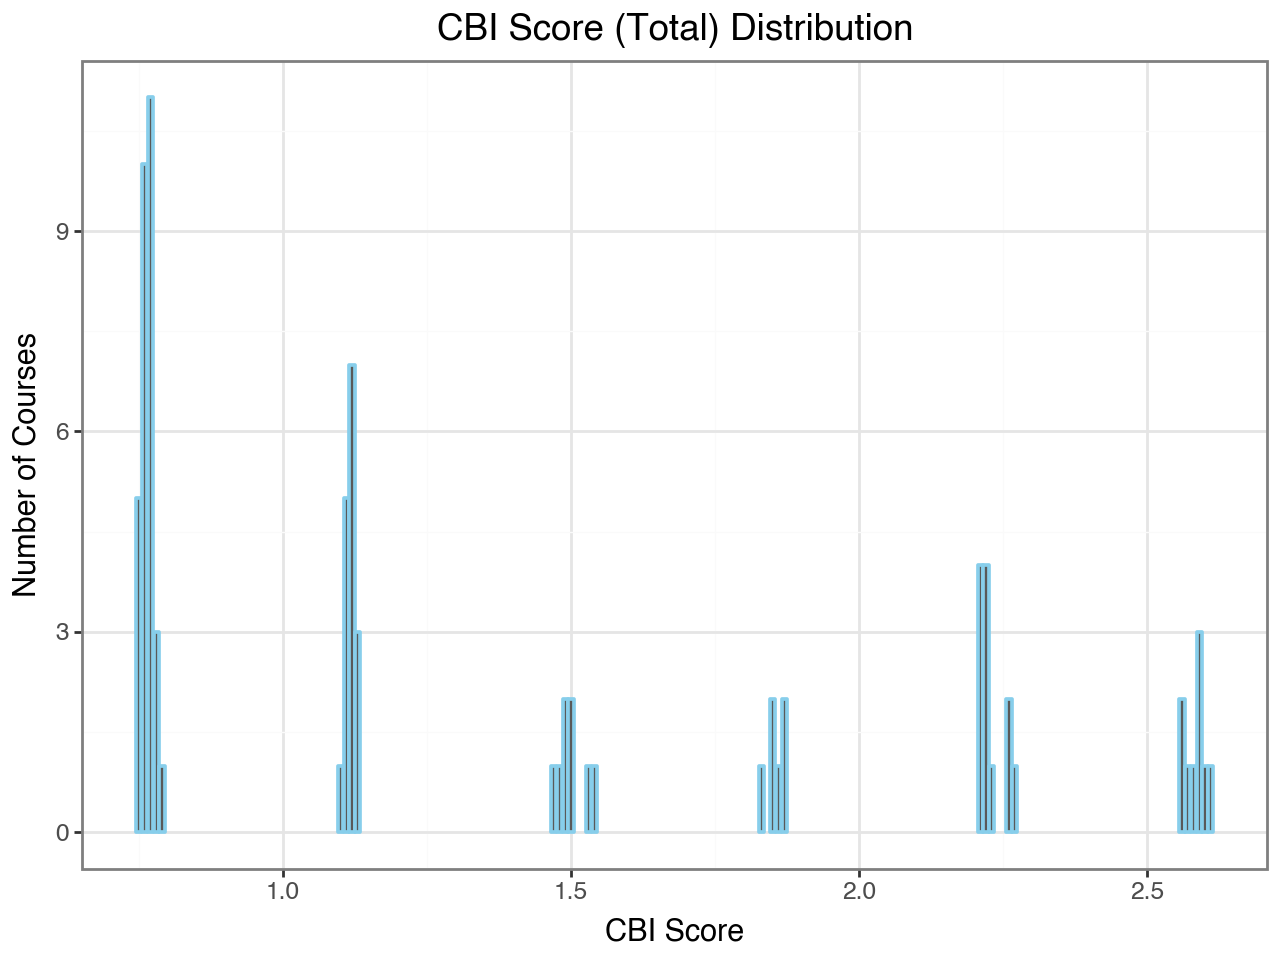

In [8]:
CBI_tot_counts = (ggplot(CBI_tot, aes(x="CBI")) +
    geom_bar(color="skyblue", size=0.75) +
    theme_bw() +
    labs(title="CBI Score (Total) Distribution", x="CBI Score", y="Number of Courses"))

CBI_tot_counts

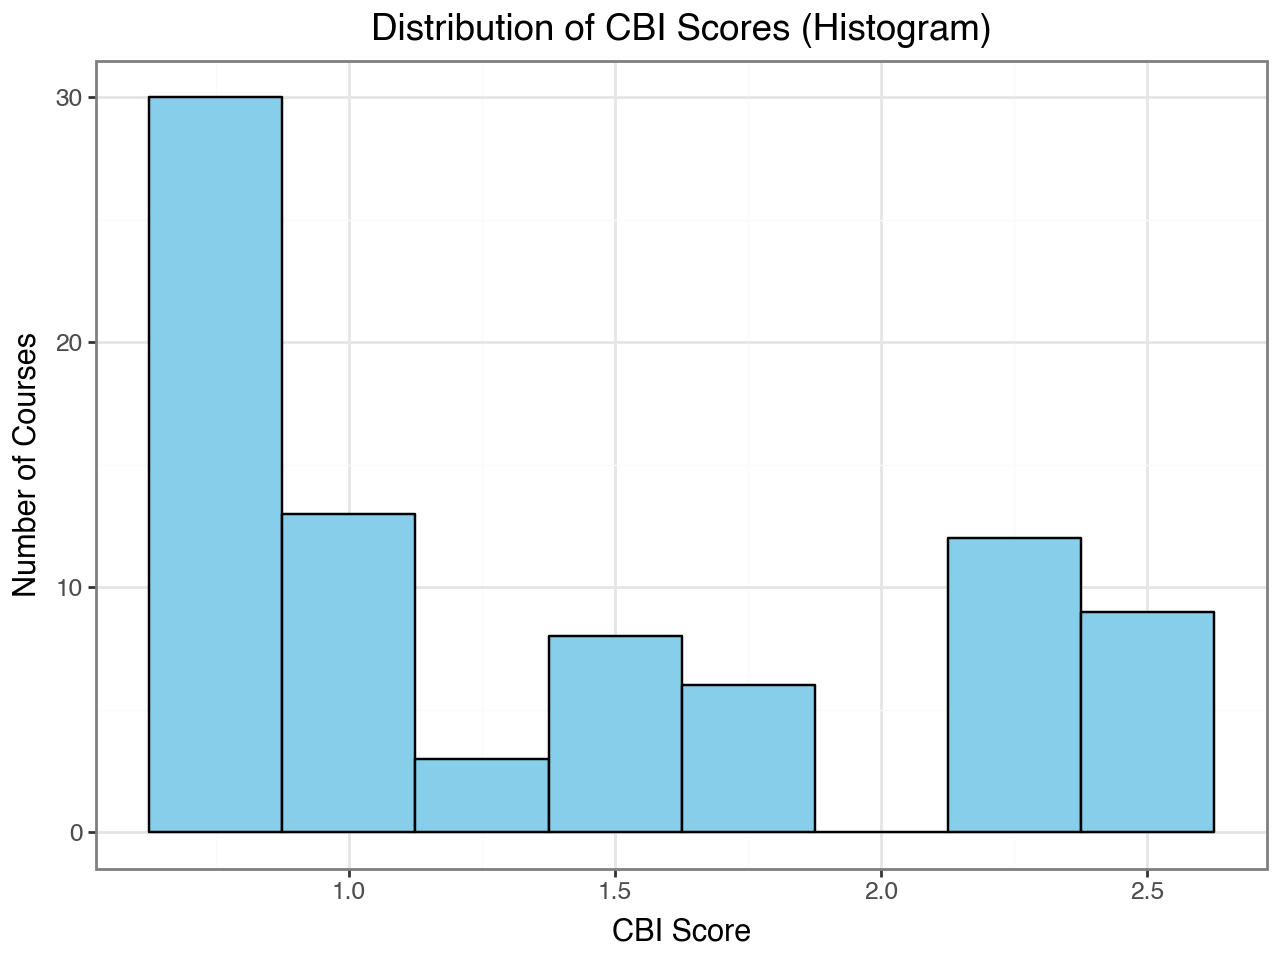

In [9]:
CBI_tot_counts_hist = (ggplot(CBI_tot, aes(x="CBI")) +
    geom_histogram(binwidth=0.25, fill="skyblue", color="black") +
    theme_bw() +
    labs(title="Distribution of CBI Scores (Histogram)", x="CBI Score", y="Number of Courses")
)

CBI_tot_counts_hist


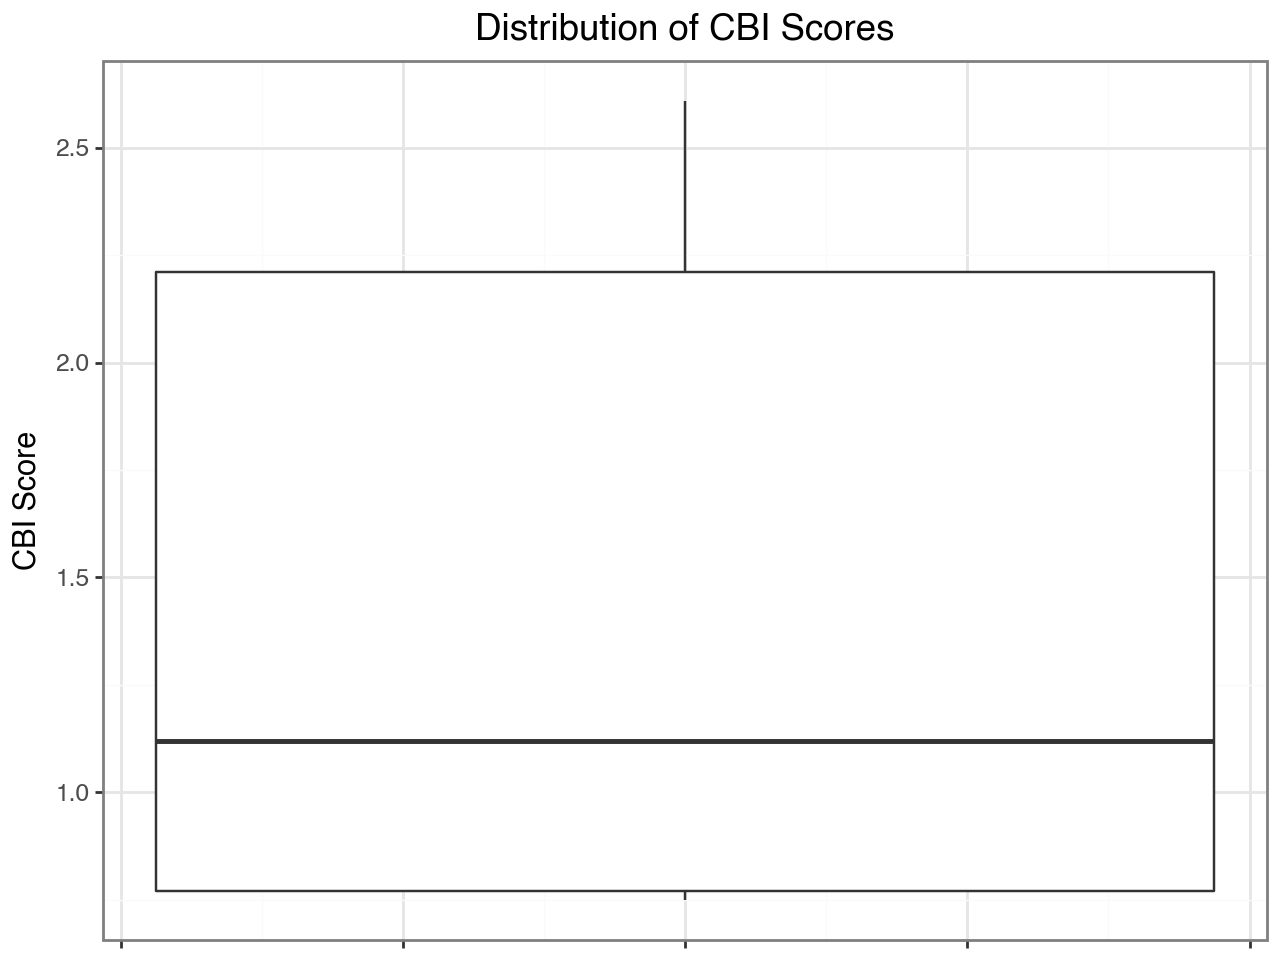

In [10]:
CBI_tot_counts_distro = (ggplot(CBI_tot, aes(y="CBI")) +
    geom_boxplot() +
    theme_bw() +
    labs(title="Distribution of CBI Scores", y="CBI Score") +
    theme(axis_text_x=element_blank())
)

CBI_tot_counts_distro 

<h1>Analyzing CBI by Term</h1>

CBI by Term 
1) Alphabetical by Term (CBI_term_alphabetical)
2) Descending CBI by Term (CBI_tot_highlow)

In [11]:
# CBI Alphabetical
CBI_term_alphabetical = CBI_term[["Term", "Course Description", "CBI"]]

# CBI Highest to Lowest
CBI_term["Term"] = pd.Categorical(CBI_term["Term"], categories=CBI_term["Term"].unique(), ordered=True) # Lock order of Terms
CBI_tot_highlow = (CBI_term[["Term", "Course Description", "CBI"]]
    .sort_values(by=["Term", "CBI"], ascending=[True, False])
    .reset_index(drop=True))

Summary Stats

In [12]:
# For Loop for our summary stats (mean, median, std, min/max) and top/bottom courses

# Empty Lists to store some summary stats for graphing
cbi_term_means = []
cbi_term_medians = []
cbi_term_stds = []

for df_semester, group in CBI_term.groupby("Term", sort=False, observed=True): # sort = False to keep my Terms in academic year order
    # Summary stats (mean, median, std)
    cbi_term_mean = round(group["CBI"].mean(), 2)                           # Mean
    cbi_term_means.append({"Term": df_semester, "Mean CBI": cbi_term_mean}) # Save Mean to cbi_term_means
    cbi_term_median = round(group["CBI"].median(), 2)                             # Median
    cbi_term_medians.append({"Term": df_semester, "Median CBI": cbi_term_median}) # Save Median to cbi_term_medians
    cbi_term_std = round(group["CBI"].std(), 2)
    cbi_term_stds.append({"Term": df_semester, "STD CBI": cbi_term_std})

    # Print summary stats
    print(f"\n🗓 CBI Summary for {df_semester}") # emoji to make it easier to read
    print(f"Mean CBI: {cbi_term_mean}")
    print(f"Median CBI: {cbi_term_median}")
    print(f"Standard Deviation: {cbi_term_std}")

    # Min/Max with course name(s)
    cbi_term_min = round(group["CBI"].min(), 2)
    cbi_term_max = round(group["CBI"].max(), 2)
    cbi_term_course_min = group.loc[group["CBI"] == cbi_term_min, "Course Description"].tolist()
    cbi_term_course_max = group.loc[group["CBI"] == cbi_term_max, "Course Description"].tolist()
    print(f"Min CBI: {cbi_term_min} on Courses: {cbi_term_course_min}")
    print(f"Max CBI: {cbi_term_max} on Courses: {cbi_term_course_max}")

    #Top/Bottom 
    high_low_count = 10
    top_cbi_term = group.nlargest(high_low_count, "CBI")[["Course Description", "CBI"]]
    bottom_cbi_term = group.nsmallest(high_low_count, "CBI")[["Course Description", "CBI"]]
    print(f"\n{df_semester}: {high_low_count} Highest CBI Courses:")
    print(top_cbi_term.to_string(index=False))
    print(f"\n {df_semester}: {high_low_count} Lowest CBI Courses:")
    print(bottom_cbi_term.to_string(index=False))



🗓 CBI Summary for Fall 2021
Mean CBI: 0.96
Median CBI: 0.92
Standard Deviation: 0.44
Min CBI: 0.55 on Courses: ['Online Searching']
Max CBI: 2.01 on Courses: ['Intro to Creative Coding']

Fall 2021: 10 Highest CBI Courses:
            Course Description  CBI
      Intro to Creative Coding 2.01
Foundation of Info & Inference 2.00
           Advanced Web Design 1.96
 Bayesian Modeling & Inference 1.94
 Applied Cyberinfrastruct Conc 1.92
    Instructional Technologies 1.63
     Designing an Installation 1.60
                Special Topics 1.60
      User Interf+Website Dsgn 1.59
Simulation and Problem Solving 1.55

 Fall 2021: 10 Lowest CBI Courses:
            Course Description  CBI
              Online Searching 0.55
              Digital Dilemmas 0.56
Digital Storytelling & Culture 0.56
         Theories of New Media 0.57
Digital Discourse and Identity 0.58
  Collaborating: Online Commun 0.59
         Database Dev and Mgmt 0.59
            Intro to Info Tech 0.59
          Quantitati

CBI by Term - Which Classes Persistently have High CBI Scores?

In [13]:
# Filter for high CBI scores (above 1)
trend_persistent_high1 = CBI_term[CBI_term["CBI"] > 1]

# Count how often each course appears
trend_persistent_high1 = (trend_persistent_high1["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate low counts for Intermittent courses
trend_intermittent_high1 = trend_persistent_high1[trend_persistent_high1["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high1 = trend_persistent_high1[trend_persistent_high1["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high1 = trend_persistent_high1[trend_persistent_high1["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1):")
print(trend_persistent_high1)


Courses with Persistent High CBI Scores (Above 1):
                Course Description  Count
0             Algorithms for Games      6
1          Artificial Intelligence      6
2    Ethical Issues in Information      6
3               Princ Data Science      6
4              Science Information      6
5            Intro to Data Science      5
6    Special Topics in Information      5
7                  Neural Networks      5
8                      Applied NLP      5
9       Narrative in Digital Games      4
10           Dig Games and Society      4
11                     Data Ethics      4
12          Government Information      4
13             Installation Design      4
14             Advanced Web Design      3
15                 Esports Casting      3
16     Info Trust and Manipulation      3
17    Computational Social Science      3
18            Business Information      3
19       Intro to Digital Cultures      3
20        Intro to Creative Coding      3
21      Instructional Tec

In [14]:
# Filter for high CBI scores (above 1.5)
trend_persistent_high15 = CBI_term[CBI_term["CBI"] > 1.5]

# Count how often each course appears
trend_persistent_high15 = (trend_persistent_high15["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate when Count = 1 for Intermittent courses
trend_intermittent_high15 = trend_persistent_high15[trend_persistent_high15["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high15 = trend_persistent_high15[trend_persistent_high15["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high15 = trend_persistent_high15[trend_persistent_high15["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1.5):")
print(trend_persistent_high15)

Courses with Persistent High CBI Scores (Above 1.5):
                Course Description  Count
0              Advanced Web Design      3
1         Intro to Creative Coding      3
2      Info Trust and Manipulation      3
3                  Esports Casting      3
4     Computational Social Science      3
5             Business Information      3
6        Intro to Digital Cultures      3
7       Instructional Technologies      3
8    Bayesian Modeling & Inference      3
9                   Special Topics      2
10        User Interf+Website Dsgn      2
11   Applied Cyberinfrastruct Conc      2
12  Foundation of Info & Inference      2
13       Designing an Installation      2
14                         Game AI      2
15   Monetizing Independent Gaming      2
16                      STEM Games      2
17           Special Topics in LIS      2


In [15]:
# Filter for high CBI scores (above 1.75)
trend_persistent_high175 = CBI_term[CBI_term["CBI"] > 1.75]

# Count how often each course appears
trend_persistent_high175 = (trend_persistent_high175["Course Description"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Count"}))

# Isolate when Count = 1 for Intermittent courses
trend_intermittent_high175 = trend_persistent_high175[trend_persistent_high175["Count"] == 1].reset_index(drop=True)
trend_intermittent2_high175 = trend_persistent_high175[trend_persistent_high175["Count"].isin([1, 2])].reset_index(drop=True)

# Keep Counts 2 & Higher
trend_persistent_high175 = trend_persistent_high175[trend_persistent_high175["Count"] > 1]

print("Courses with Persistent High CBI Scores (Above 1.75):")
print(trend_persistent_high175)

Courses with Persistent High CBI Scores (Above 1.75):
               Course Description  Count
0             Advanced Web Design      3
1   Bayesian Modeling & Inference      3
2        Intro to Creative Coding      3
3    Computational Social Science      3
4   Applied Cyberinfrastruct Conc      2
5  Foundation of Info & Inference      2
6                         Game AI      2
7                      STEM Games      2


CBI by Trend - Courses with Intermittent High CBI Scores 

In [16]:
print("Courses with 1-2 Intermittent High CBI Scores (Above 1):")
print(trend_intermittent2_high1)

print("\nCourses with 1-2 Intermittent High CBI Scores (Above 1.5):")
print(trend_intermittent2_high15)

print("\nCourses with 1-2 Intermittent High CBI Scores (Above 1.75):")
print(trend_intermittent2_high175)

Courses with 1-2 Intermittent High CBI Scores (Above 1):
                Course Description  Count
0         User Interf+Website Dsgn      2
1                   Special Topics      2
2   Foundation of Info & Inference      2
3        Designing an Installation      2
4                          Game AI      2
5    Applied Cyberinfrastruct Conc      2
6    Monetizing Independent Gaming      2
7                       STEM Games      2
8            Special Topics in LIS      2
9   Simulation and Problem Solving      1
10     Natural Language Processing      1
11         Visual Content Creation      1

Courses with 1-2 Intermittent High CBI Scores (Above 1.5):
                Course Description  Count
0                   Special Topics      2
1         User Interf+Website Dsgn      2
2    Applied Cyberinfrastruct Conc      2
3   Foundation of Info & Inference      2
4        Designing an Installation      2
5                          Game AI      2
6    Monetizing Independent Gaming      2
7

In [17]:
print("Courses with 1 Intermittent High CBI Scores (Above 1):")
print(trend_intermittent_high1)

print("\nCourses with 1 Intermittent High CBI Scores (Above 1.5):")
print(trend_intermittent_high15)

print("\nCourses with 1 Intermittent High CBI Scores (Above 1.75):")
print(trend_intermittent_high175)

Courses with 1 Intermittent High CBI Scores (Above 1):
               Course Description  Count
0  Simulation and Problem Solving      1
1     Natural Language Processing      1
2         Visual Content Creation      1

Courses with 1 Intermittent High CBI Scores (Above 1.5):
               Course Description  Count
0  Simulation and Problem Solving      1
1     Natural Language Processing      1
2                 Neural Networks      1
3         Visual Content Creation      1

Courses with 1 Intermittent High CBI Scores (Above 1.75):
            Course Description  Count
0  Natural Language Processing      1


<h3>CBI by Term - Trend Analysis</h3>

In [18]:
# Lists from Summary Stats - convert to DFs for graphing
df_means = pd.DataFrame(cbi_term_means, columns=["Term", "Mean CBI"])
df_medians = pd.DataFrame(cbi_term_medians, columns=["Term", "Median CBI"])
df_stds = pd.DataFrame(cbi_term_stds, columns=["Term", "STD CBI"])

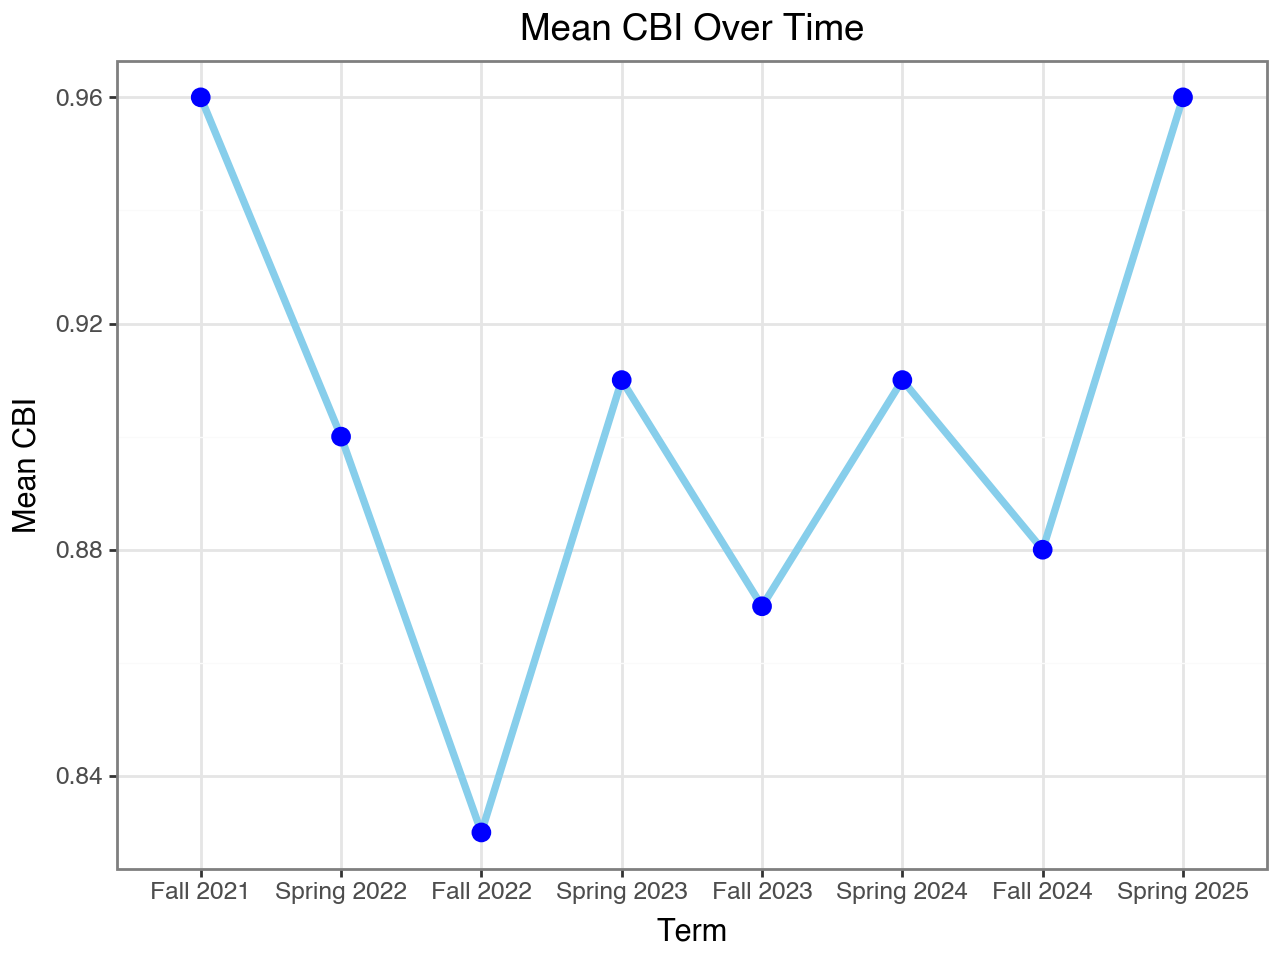

In [19]:
# Lock Terms in order
df_means["Term"] = pd.Categorical(df_means["Term"], categories=df_means["Term"], ordered=True)

trend_term_means = (ggplot(df_means, aes(x="Term", y="Mean CBI", group=1)) +
    geom_line(color="skyblue", size=1.5) + 
    geom_point(color="blue", size=3) + 
    theme_bw() +
    labs(title="Mean CBI Over Time", x="Term", y="Mean CBI") +
    theme(axis_text_x=element_text(hjust=0.5))
)

trend_term_means

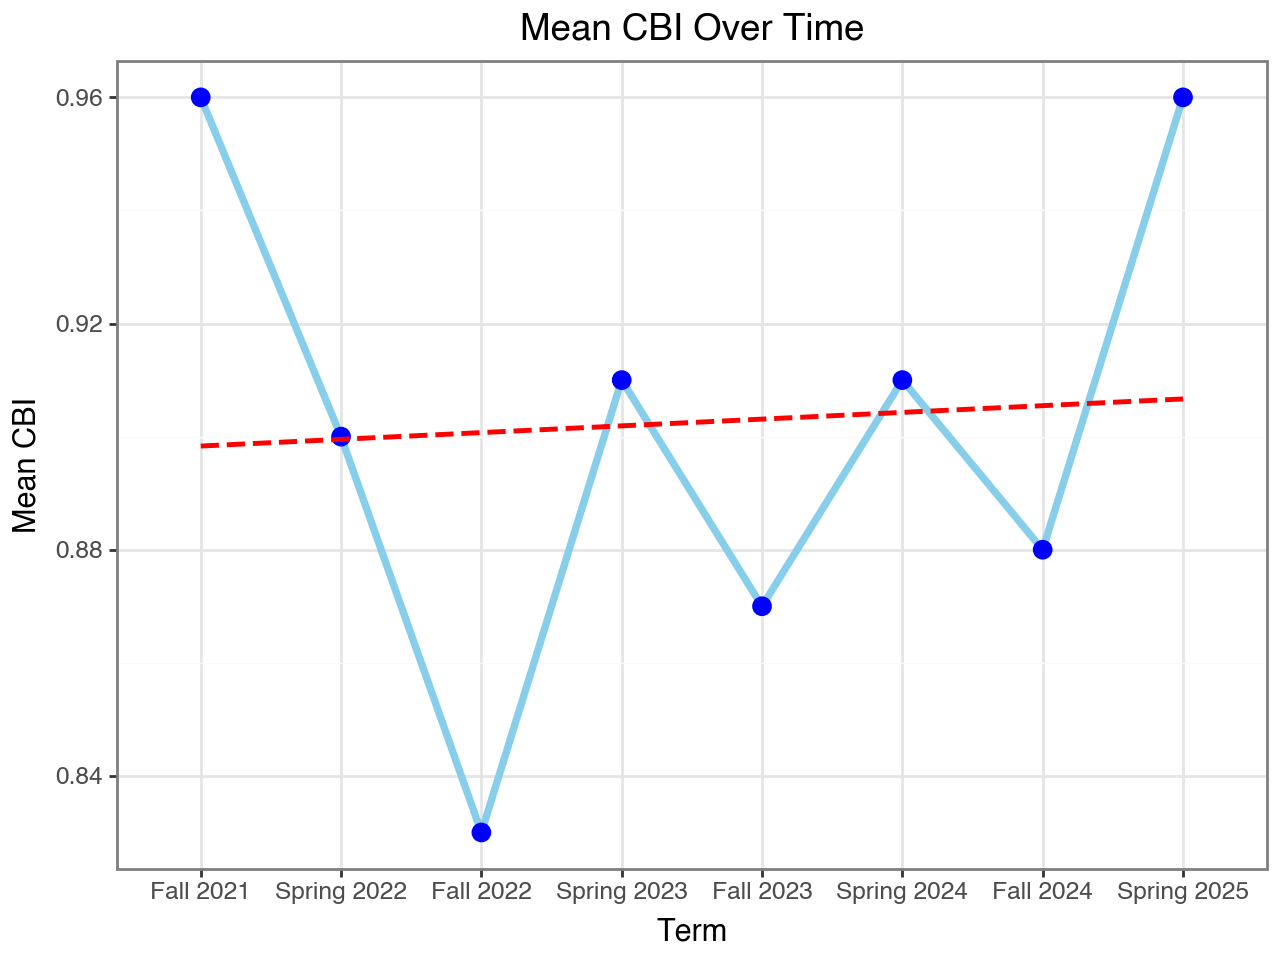

In [20]:
trend_term_means_lm = trend_term_means + geom_smooth(method='lm', color="red", linetype="dashed", se=False)
trend_term_means_lm

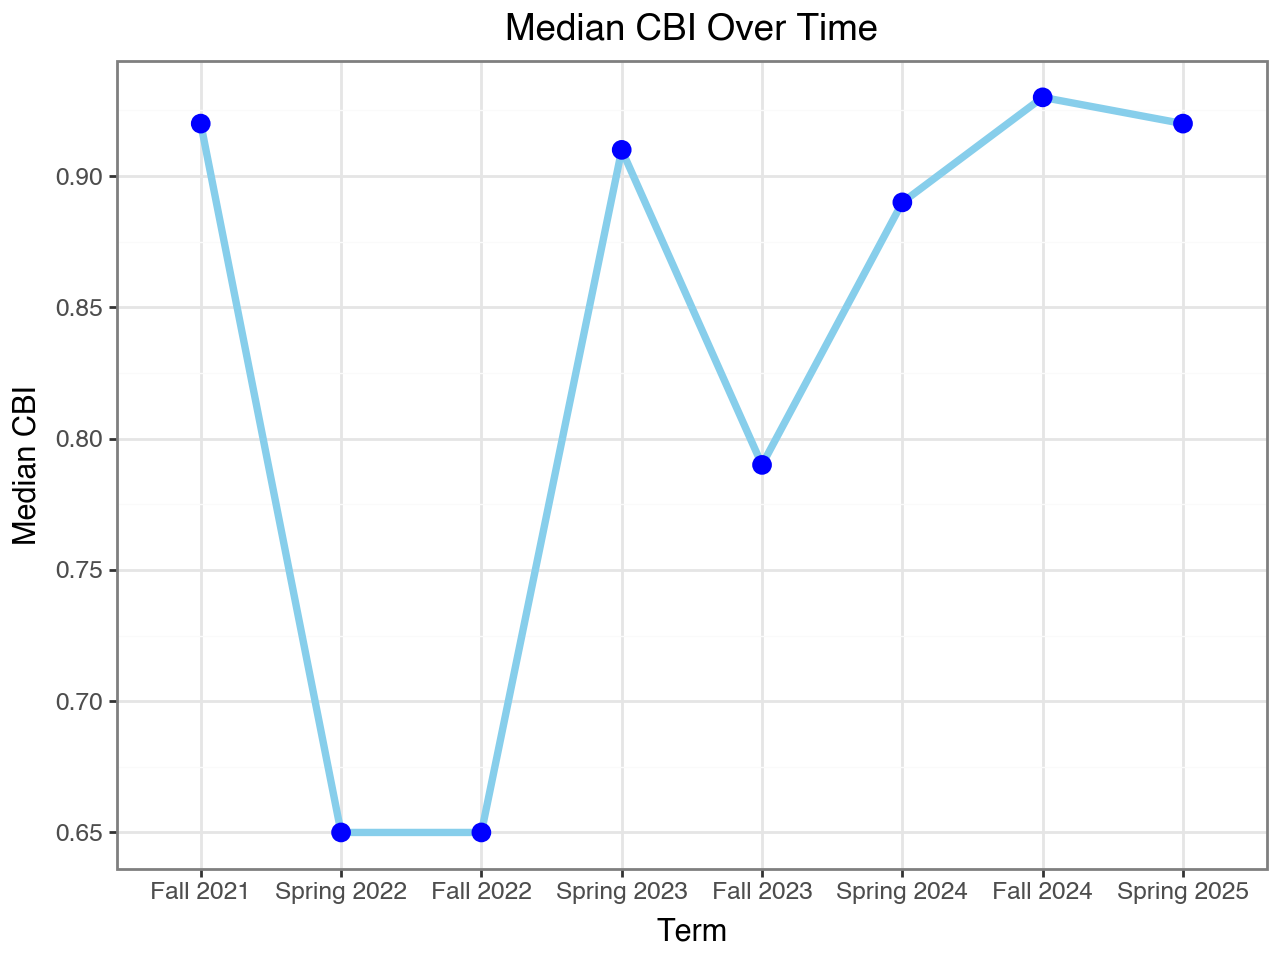

In [21]:
# Lock Terms in order
df_medians["Term"] = pd.Categorical(df_medians["Term"], categories=df_medians["Term"], ordered=True)

trend_term_median = (ggplot(df_medians, aes(x="Term", y="Median CBI", group=1)) +
    geom_line(color="skyblue", size=1.5) + 
    geom_point(color="blue", size=3) + 
    theme_bw() +
    labs(title="Median CBI Over Time", x="Term", y="Median CBI") +
    theme(axis_text_x=element_text(hjust=0.5))
)

trend_term_median

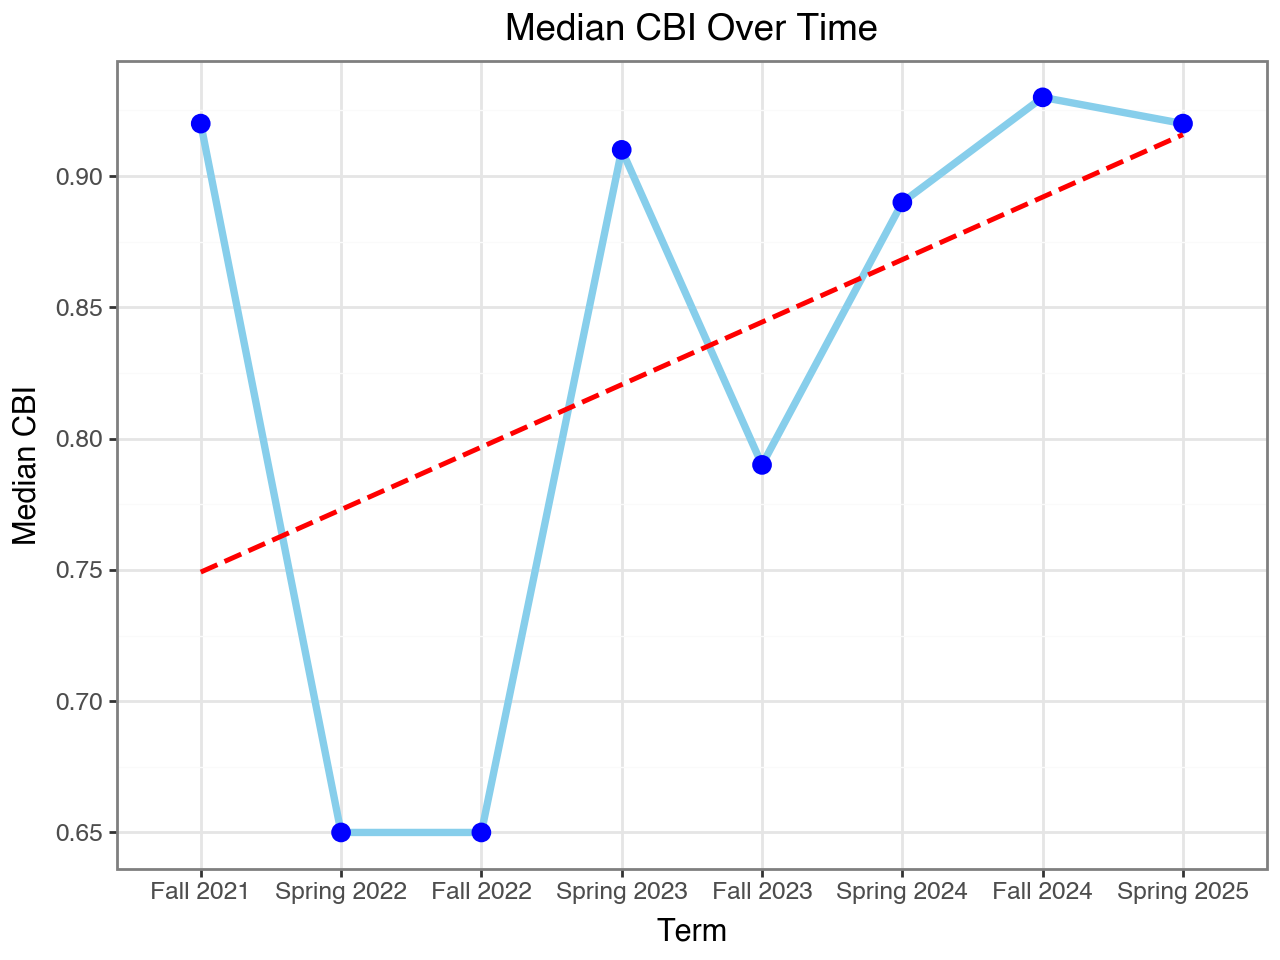

In [22]:
trend_term_median_lm = trend_term_median + geom_smooth(method='lm', color="red", linetype="dashed", se=False)
trend_term_median_lm

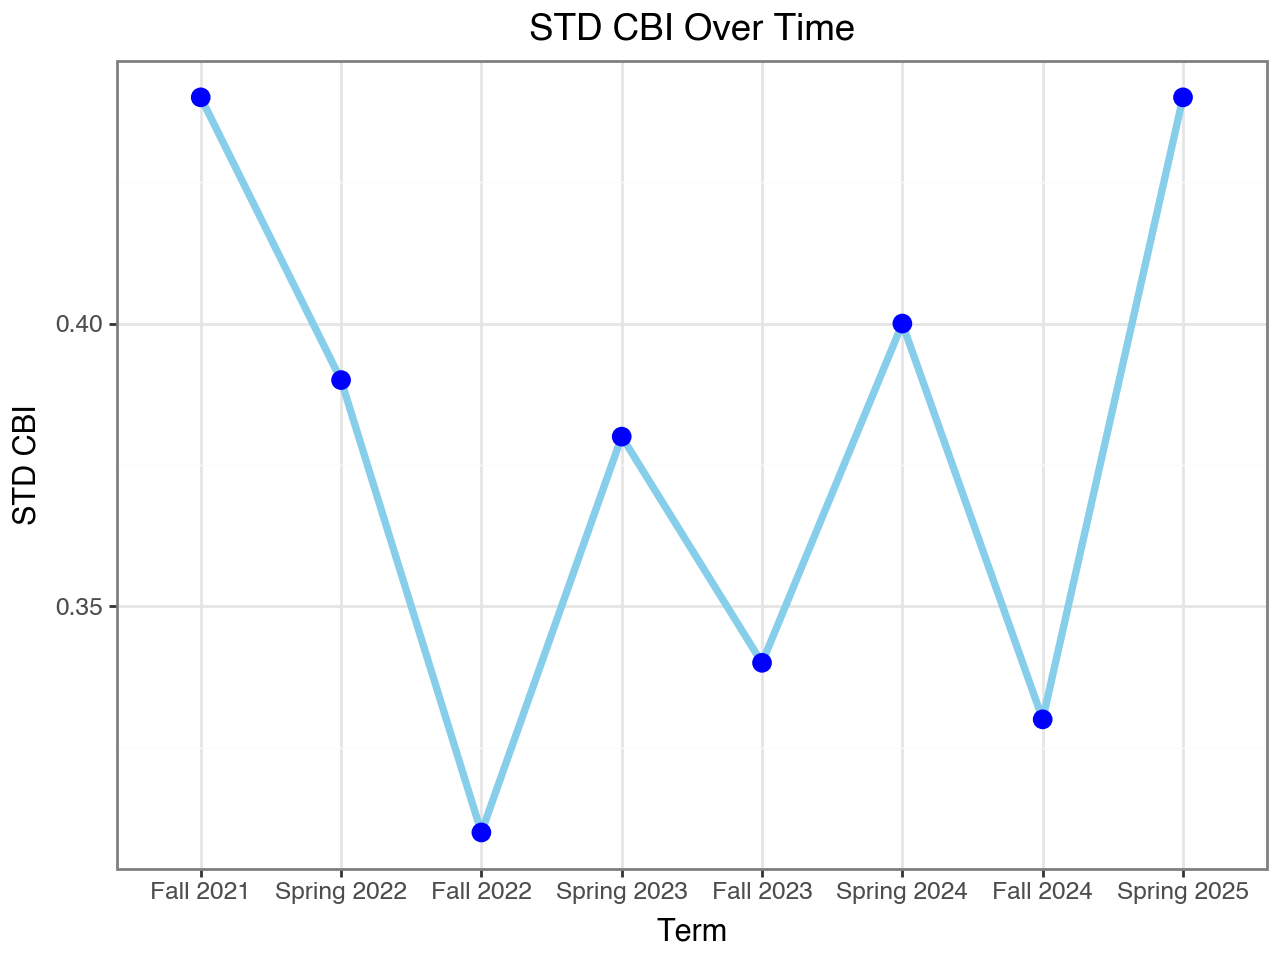

In [23]:
# Lock Terms in order
df_stds["Term"] = pd.Categorical(df_stds["Term"], categories=df_stds["Term"], ordered=True)

trend_term_std = (ggplot(df_stds, aes(x="Term", y="STD CBI", group=1)) +
    geom_line(color="skyblue", size=1.5) + 
    geom_point(color="blue", size=3) + 
    theme_bw() +
    labs(title="STD CBI Over Time", x="Term", y="STD CBI") +
    theme(axis_text_x=element_text(hjust=0.5))
)

trend_term_std

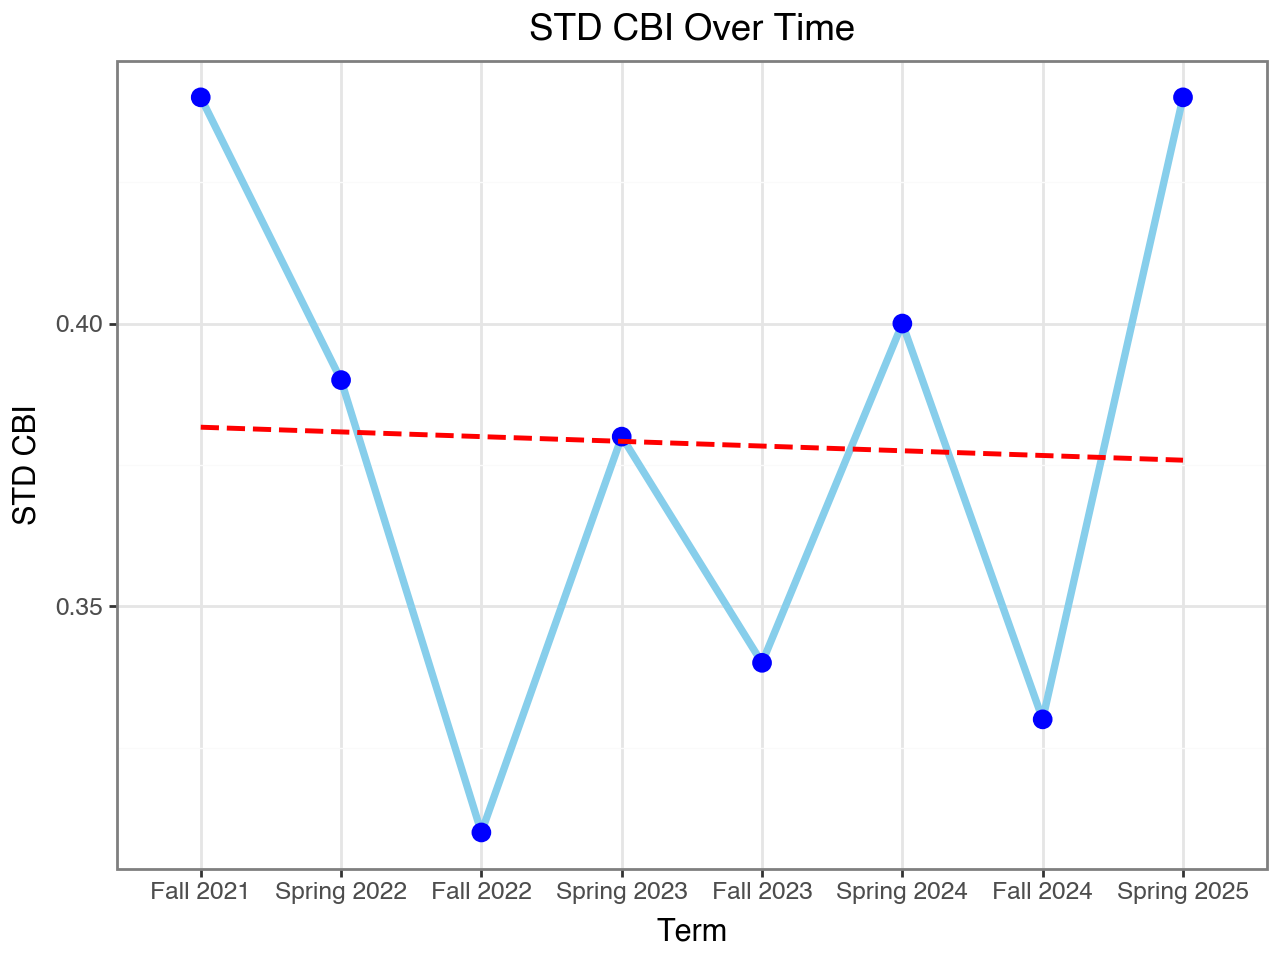

In [24]:
trend_term_std_lm = trend_term_std + geom_smooth(method='lm', color="red", linetype="dashed", se=False)
trend_term_std_lm